## <center> MODULEBANK HACKATON
    

<center> https://boosters.pro/champ_modulbank_msk?success=0

In [4]:
import pandas as pd
import numpy as np 
import pandas_profiling as pp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import auc , roc_curve, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.simplefilter('ignore')

import matplotlib.style as stl 
stl.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (25, 25)

In [5]:
train = pd.read_csv('../data/train_5.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/test_5.csv', sep='\t', index_col=0 )

In [3]:
pp.ProfileReport(train)

In [4]:
pp.ProfileReport(test)

In [6]:
test_higly_corr = [(9, 2)]
test_constant_cols = [11, 129, 130, 137, 138, 140, 141, 149, 150, 164,
                      178, 186, 188, 192, 193, 291, 301, 303, 305, 5]
train_highly_corr = [(153, 17), (9, 2)]
train_constant_cols = [152, 160, 164, ]

train.columns = range(0, train.shape[1] ) 
test.columns = range(0, test.shape[1] ) 

for feature in train_constant_cols:
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
#some binary features in train are constant in test. 
#deleting rows from train where value of these features doesn't match the value in test 
for feature in set(test_constant_cols).difference(set(train_constant_cols)):
    test_value = test[feature].unique()[0]
    train = train[train[feature]==test_value]
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True) 
    
for features in train_highly_corr:
    train.drop([features[0]], axis=1, inplace=True)
    test.drop([features[0]], axis=1, inplace=True)   
    
xtrain = train.iloc[:, 1:]
xtest = test.iloc[:, 1:]
ytrain = train.iloc[:, 0]

### ========================================================================================

In [7]:
def to_submission(predictions, filename):
    seria = pd.Series(predictions, name='_VAL_')
    seria.to_csv(filename, header=True, index_label='_ID_')

In [8]:
seed = 42
skf = StratifiedKFold(n_splits=7, random_state=seed)

In [9]:
def get_results(estimator, skf, xtrain, ytrain, xtest):
    estimator.fit(xtrain, ytrain)
    predictions = estimator.predict_proba(xtest)[:, 1]
    
    predictions_cv = []
    for train_idx, val in skf.split(xtrain, ytrain):
        estimator.fit(xtrain.iloc[train_idx], ytrain.iloc[train_idx])
        predictions_cv.append([ytrain.iloc[val], estimator.predict_proba(xtrain.iloc[val])[:,1]])

    return predictions, predictions_cv

### ========================================================================================

#### LOGISTIC REGRESSION

In [10]:
%%time
lg = LogisticRegression(random_state=42, penalty='l2' )
param_grid = {'C': [0.01, 0.05, 0.1, 0.15, 0.2, 1],#[]
              'solver': ['liblinear', 'sag']} # ['newton-cg' , 'lbfgs']
grid_cv_lg = GridSearchCV(lg,param_grid, cv=skf, scoring='roc_auc', verbose=1, n_jobs=4)
grid_cv_lg.fit(xtrain, ytrain)
best_log = grid_cv_lg.best_estimator_

Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:  2.2min finished


CPU times: user 19.3 s, sys: 150 ms, total: 19.5 s
Wall time: 2min 19s


In [11]:
log_predictions, log_predictions_cv = get_results(best_log, skf, xtrain, ytrain, xtest)

log_score = grid_cv_lg.best_score_
print(f"CV score {log_score}")

CV score 0.727872499429575


#### RANDOM FOREST CLASSIFIER 

In [12]:
%%time
rf = RandomForestClassifier(random_state=42, criterion='entropy', n_jobs=4)
param_grid = {'max_features': (  0.2, 0.5, 1),
            'max_depth': (15, 20, 25),
            'min_samples_leaf':(10,2),
            'n_estimators':(50, 75)} 
grid_cv_rf = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc', verbose=1, n_jobs=4)
grid_cv_rf.fit(xtrain, ytrain)
best_rf = grid_cv_rf.best_estimator_
rf_score = grid_cv_rf.best_score_
print(f"CV score {rf_score}")

rf_predictions, rf_predictions_cv = get_results(best_rf, skf, xtrain, ytrain, xtest)

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 32.4min
[Parallel(n_jobs=4)]: Done 252 out of 252 | elapsed: 75.6min finished


CV score 0.7359321393466518
CPU times: user 14min 48s, sys: 2.27 s, total: 14min 50s
Wall time: 1h 19min 26s


#### BAGGING

In [14]:
best_bag = BaggingClassifier(base_estimator=best_log, n_estimators=50, max_features=0.95, n_jobs=4)
bag_score = cross_val_score(best_bag, xtrain, ytrain, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
print(f"CV score {bag_score}")

bag_predictions, bag_predictions_cv = get_results(best_bag, skf, xtrain, ytrain, xtest)

CV score 0.7288067107579708


#### MLP

In [14]:
%%time
best_mlp =  MLPClassifier(activation='logistic')
mlp_score = cross_val_score(best_mlp, xtrain, ytrain, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc').mean()
print(f"CV score {mlp_score}")

mlp_predictions, mlp_predictions_cv = get_results(best_mlp, skf, xtrain, ytrain, xtest)

[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  3.2min finished


CV score 0.7126738444851461
CPU times: user 8min 21s, sys: 26.6 s, total: 8min 48s
Wall time: 7min 34s


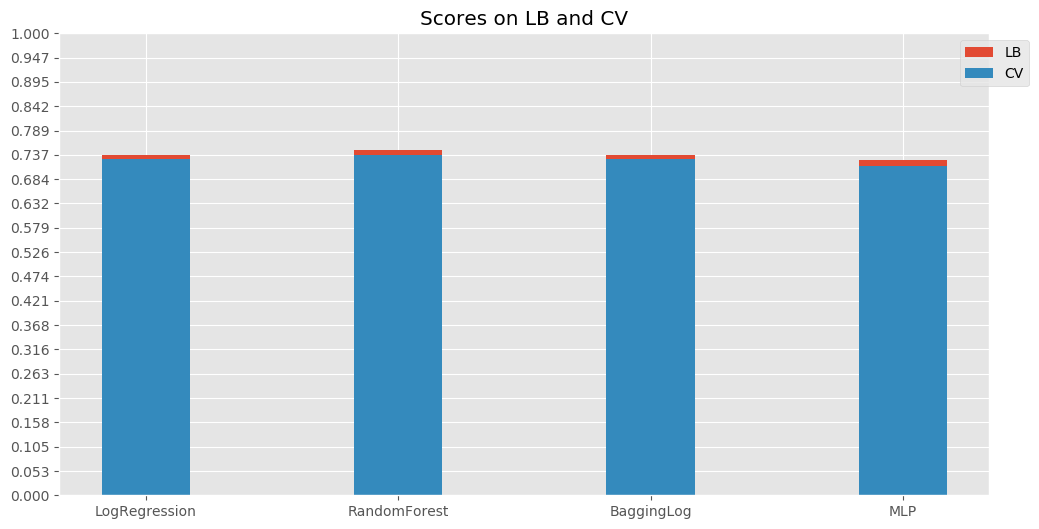

In [51]:
cv_scores = [log_score, rf_score, bag_score, mlp_score]
lb_scores = [0.7369, 0.7466, 0.7375, 0.7263 ]
estimators = ['LogRegression', 'RandomForest', 'BaggingLog', 'MLP']
stl.use('ggplot')
ind = np.arange(len(estimators))    # the x locations
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.rcParams['figure.figsize'] = 12, 6
p1 = plt.bar(ind, lb_scores, width), 
p2 = plt.bar(ind, cv_scores, width)

plt.title('Scores on LB and CV')
plt.xticks(ind, (estimators))
plt.yticks(np.linspace(0, 1, 20),  )
plt.legend((p1[0], p2[0]), ('LB', 'CV'), bbox_to_anchor=(1.05, 1))


### ====================================================================================

 ##  SIMPLE ENSEMBLES 

###  WEIGHTED AVERAGE

Best score is 0.7419302402135921


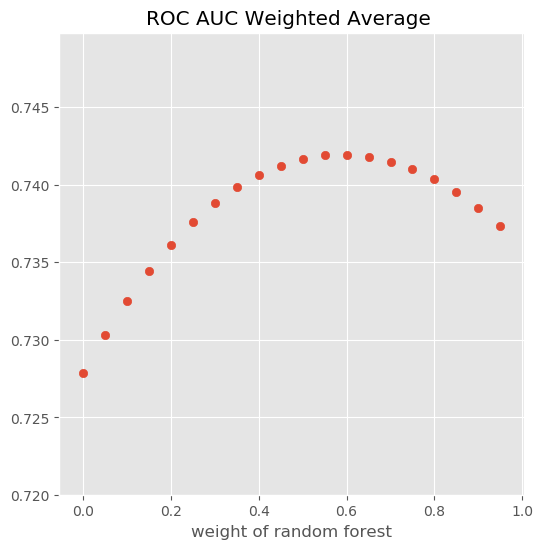

In [52]:
# simple weighted average
mus = np.arange(0, 20) * 0.05
scores = [np.mean([roc_auc_score(rf_p[0], rf_p[1]*mu + lg_p[1]*(1-mu)) for rf_p, lg_p in zip(rf_predictions_cv, log_predictions_cv)])\
          for mu in mus]
print(f"Best score is {np.max(scores)}")
#vizualizing
plt.rcParams['figure.figsize'] = 6, 6
plt.title('ROC AUC Weighted Average ')
plt.xlabel('weight of random forest', fontsize=12)
plt.scatter(mus, scores)   
# PublicLB 0.7481

###  GEOMETRIC AVERAGE

In [54]:
np.mean([roc_auc_score(rf_p[0], np.sqrt(rf_p[1]*et_p[1])) for rf_p, et_p in zip(rf_predictions_cv, log_predictions_cv)])

0.74158376075501753

###  RANK DATA

In [55]:
from scipy.stats import rankdata
np.mean([roc_auc_score(rf_p[0], rankdata(rf_p[1]) + rankdata(et_p[1])) for rf_p, et_p in zip(rf_predictions_cv, log_predictions_cv)])

0.74075140232759284

### ====================================================================================

 ##  ENSEMBLES 

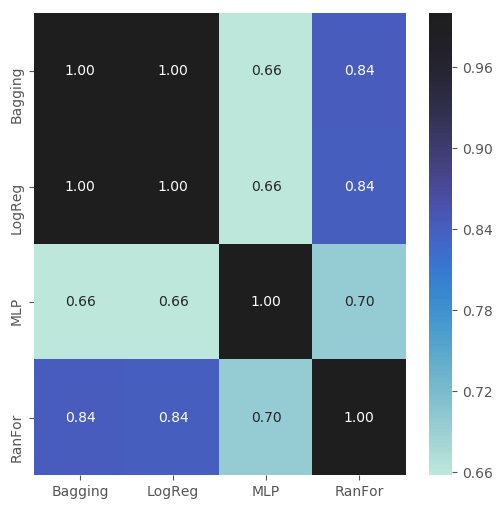

In [57]:
preds = pd.DataFrame({'LogReg': log_predictions, 'RanFor':rf_predictions,
              'MLP' : mlp_predictions, 'Bagging': bag_predictions})
sns.heatmap(preds.corr(), annot=True, fmt='.2f', center = True)

In [58]:
# Bagging on Log reg and log reg are highly correlated but it gives significant boost on score(why?)

In [69]:
xtrain_stacked = xtrain.copy()
xtest_stacked = xtest.copy()

xtrain_stacked["log_preds"] = 0
xtrain_stacked["rf_preds"] = 0
xtrain_stacked["bag_preds"] = 0


xtest_stacked["log_preds"] = log_predictions
xtest_stacked["rf_preds"] = rf_predictions
xtest_stacked["bag_preds"] = bag_predictions

for i, fold in enumerate(skf.split(xtrain, ytrain)):
    train, val = fold[0], fold[1]
    xtrain_stacked.iloc[val, -3] = log_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -2] = rf_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -1] = bag_predictions_cv[i][1]
 
    

In [70]:
meta_estmator = LogisticRegression(penalty='l1', random_state=seed)
meta_estmator.fit(xtrain_stacked, ytrain)
stacked_predictions = meta_estmator.predict_proba(xtest_stacked)[:, 1]

In [72]:
base_stack_score = cross_val_score(meta_estmator, xtrain_stacked, ytrain, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
print(f"CV score {base_stack_score}")
#LB 0.7502

CV score 0.746887197347692


### ====================================================================================

 ## ALSO TRIED  (See later in another notebook)

In [15]:
#  просто спроби вдосконалити зіпсували  вигляд  і я все видалила 

### 1. Feature engineering:
  <br>  -adding all possible statistics about binary columns (+ 0.00x on validation,  on lb -)
  <br>  -adding poly features about numerical features ( -0.0x on validation)
  <br>  -union high correlated featured 
  <br>  -sum of sparsed columns, deleted sparsed columns (+ 0.00x but it seemed to be a validation error) 
### <br>2. Stacking:
   <br>    -different meta_algoritms 
   <br>    -different base algorithms
### <br>3. Blending:
   <br>-simple blending
   <br> -average of blending predictions
### <br>4. Handling imbalanced data :
   <br> SMOTE + RandomForest, SMOOTEK, oversampling, undersampling , .... -> + on cross val , fail on lb 